## Imports

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 27.2 MB/s 
     |████████████████████████████████| 419 kB 70.8 MB/s 
     |████████████████████████████████| 1.1 MB 62.3 MB/s 
     |████████████████████████████████| 271 kB 71.0 MB/s 
     |████████████████████████████████| 144 kB 25.6 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 


In [ ]:
!pip install git+https://github.com/undark-lab/swyft.git@lightning-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/undark-lab/swyft.git (to revision lightning-dev) to /tmp/pip-req-build-2je_xuvx
  Running command git clone -q https://github.com/undark-lab/swyft.git /tmp/pip-req-build-2je_xuvx
  Running command git checkout -b lightning-dev --track origin/lightning-dev
  Switched to a new branch 'lightning-dev'
  Branch 'lightning-dev' set up to track remote branch 'lightning-dev' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
from math import ceil, log10, pi, sqrt

import matplotlib.pyplot as plt
import swyft.lightning.components as sl
import torch
import torch.distributions as dist

## Simulator setup

In [ ]:
from functools import lru_cache


def get_meshgrid(resolution, nx, ny, device=None):
    """
    Constructs meshgrids.
    """
    dx = resolution
    dy = resolution

    # Coordinates at pixel centers
    x = torch.linspace(-1, 1, int(nx), device=device) * (nx - 1) * dx / 2
    y = torch.linspace(-1, 1, int(ny), device=device) * (ny - 1) * dy / 2

    # Note difference to numpy (!)
    Y, X = torch.meshgrid((y, x), indexing='ij')

    return X, Y


class Simulator(sl.Simulator):
    extent: float = 15  # observation size [deg]
    n_pix: int = 64
    d_gc: float = 8.3
    """Distance to galactic center [kpc]."""

    sigma_pi0: float = 0.25
    """Length scale associated with spatial variations in pi0 emission [deg]."""

    pi0_disk_height: float = 5.0
    """Disk height for pi0 emission"""

    pi0_disk_radius: float = 20.0
    """Disk radius for pi0 emission"""

    disk_height_ic: float = 5.0
    """Disk height for IC emission [deg]."""

    bubble_smoothing_scale: float = 0.6
    """Smoothing scale for Fermi bubble template [deg]."""

    ps_disk_height: float = 0.3
    """Disk scale height for disk-correlated point sources [kpc]."""

    ps_disk_radius: float = 5.0
    """Disk scale radius for disk-correlated point sources [kpc]."""

    dm_dist_concentration: float = 0.5
    """Steepness of DM emission."""

    dm_dist_scale: float = 5.0
    """Spatial scale of DM emission [deg]."""

    containment_radius: float = 0.8 / 3
    """Very approximate 68% containment radius for PSF [deg]."""

    @property
    def resolution(self):
        return 2 * self.extent / self.n_pix

    @property
    @lru_cache(maxsize=1)
    def XY(self):
        return get_meshgrid(self.resolution, self.n_pix, self.n_pix)

    @property
    def X(self):
        return self.XY[0]

    @property
    def Y(self):
        return self.XY[1]

    @property
    @lru_cache(maxsize=1)
    def kernel_pi0(self):
        pts = torch.stack([self.X.flatten(), self.Y.flatten()])
        d2s = ((pts[:, :, None] - pts[:, None, :]) ** 2).sum(0)
        return (-d2s / (2 * self.sigma_pi0**2)).exp()

    @property
    @lru_cache(maxsize=1)
    def psf_kernel(self):
        X_k, Y_k = get_meshgrid(self.resolution, 5, 5)
        kernel = torch.exp(-(X_k**2 + Y_k**2) / (2 * self.containment_radius**2))
        return kernel / kernel.sum()

    def sample_pi0(self):
        # Manually rescale to make it look more realistic
        emission = (self.kernel_pi0 @ torch.randn(self.n_pix**2)).reshape(
            self.n_pix, self.n_pix
        )
        emission = 50 * torch.exp(emission / 8)
        return (
            emission
            * torch.exp(-((self.X / self.pi0_disk_radius) ** 2))
            * torch.exp(-((self.Y / self.pi0_disk_height) ** 2))
        )

    def emission_ic(self):
        return 25 * torch.exp(-self.Y.abs() / self.disk_height_ic)

    def emission_bubbles(self):
        Y_norths = 10.5 * (torch.cosh((-self.X - 1) / 10.5) - 1) + 1
        Y_souths = -8.7 * (torch.cosh((-self.X + 1.7) / 8.7) - 1) - 1
        # Apply some hacky smoothing to the edges of the bubbles
        emission = torch.zeros([self.n_pix, self.n_pix])
        emission[self.Y > 0] = torch.sigmoid(
            (self.Y[self.Y > 0] - Y_norths[self.Y > 0]) / self.bubble_smoothing_scale
        )
        emission[self.Y < 0] = torch.sigmoid(
            (Y_souths[self.Y < 0] - self.Y[self.Y < 0]) / self.bubble_smoothing_scale
        )
        return 3 * emission

    def emission_dm(self):
        """
        Computes smooth emission from DM annihilation.
        """
        dm_dist = dist.Gamma(self.dm_dist_concentration, 1 / self.dm_dist_scale)
        # Distance to galactic center
        rs = torch.sqrt(self.X**2 + self.Y**2)
        return 100 * dm_dist.log_prob(rs).exp()

    def _sample_ps_gc_helper(self, n: int):
        # Use same distribution as for DM emission
        ps_gc_dist = dist.Gamma(self.dm_dist_concentration + 1, 1 / self.dm_dist_scale)
        rs = ps_gc_dist.sample((n,))
        angles = torch.rand(n) * 2 * pi
        xs = rs * torch.cos(angles)
        ys = rs * torch.sin(angles)
        return xs, ys

    def _sample_ps_disk_helper(self, n: int):
        # Convert to degrees
        scale_radius = self.ps_disk_radius / self.d_gc * 180 / pi
        scale_height = self.ps_disk_height / self.d_gc * 180 / pi

        rs = dist.Exponential(1 / scale_radius).sample((n,))
        ys = dist.Exponential(1 / scale_height).sample((n,))

        # Randomly put pulsars above or below the galactic plane
        ys *= 2 * ((torch.rand(n) > 0.5).float() - 0.5)

        # Project radial coordinate
        angles = 2 * pi * torch.rand(n)
        xs = rs * torch.cos(angles)

        return xs, ys

    def _generate_pss(self, n: int, pos_sampler, ps_log_flux_mean, ps_log_flux_scale):
        """
        Generates a pixelated map with randomly-sampled point sources.
        """
        # Sample fluxes
        fluxes = dist.LogNormal(ps_log_flux_mean, ps_log_flux_scale).sample((n,))

        # Sample positions
        xs, ys = pos_sampler(n)
        while True:
            idx_oob = (xs.abs() > self.extent) | (ys.abs() > self.extent)
            n_oob = idx_oob.sum()
            if n_oob == 0:
                break
            else:
                xs[idx_oob], ys[idx_oob] = pos_sampler(n_oob)

        # Map onto pixel grid
        bins = torch.linspace(-self.extent, self.extent, self.n_pix + 1)
        return torch.histogramdd(
            torch.stack([ys, xs], 1), bins=(bins, bins), weight=fluxes
        ).hist

    def sample_ps_gc(self, n: int, ps_log_flux_mean, ps_log_flux_scale):
        """
        Samples point sources with the same spatial distribution as the DM emission.
        """
        return self._generate_pss(
            n, self._sample_ps_gc_helper, ps_log_flux_mean, ps_log_flux_scale
        )

    def sample_ps_disk(self, n: int, ps_log_flux_mean, ps_log_flux_scale):
        """
        Samples point sources correlated with the disk.
        """
        return self._generate_pss(
            n, self._sample_ps_disk_helper, ps_log_flux_mean, ps_log_flux_scale
        )

    def forward(self, trace: sl.Trace):
        """
        Simulate all the emission components
        """
        A_ic = trace.sample("A_ic", torch.rand, 1)
        A_pi0 = trace.sample("A_pi0", torch.rand, 1)
        A_bubbles = trace.sample("A_bubbles", torch.rand, 1)
        A_dm = trace.sample("A_dm", torch.rand, 1)
        n_ps_gc = trace.sample("n_ps_gc", torch.randint, low=200, high=800, size=(1,))
        n_ps_disk = trace.sample(
            "n_ps_disk", torch.randint, low=1000, high=4000, size=(1,)
        )
        ps_log_flux_mean = 1.0
        ps_log_flux_scale = 1.2

        # Mean emission
        mu = trace.sample(
            "mu",
            lambda A_ic, A_pi0, A_dm, A_bubbles, n_ps_gc, n_ps_disk: (
                A_ic * self.emission_ic()
                + A_pi0 * self.sample_pi0()
                + A_dm * self.emission_dm()
                + A_bubbles * self.emission_bubbles()
                + self.sample_ps_gc(n_ps_gc, ps_log_flux_mean, ps_log_flux_scale)
                + self.sample_ps_disk(n_ps_disk, ps_log_flux_mean, ps_log_flux_scale)
            ),
            A_ic,
            A_pi0,
            A_dm,
            A_bubbles,
            n_ps_gc,
            n_ps_disk,
        )

        # Convolve with PSF and add noise
        obs = trace.sample(
            "obs",
            lambda mu: dist.Poisson(
                torch.nn.functional.conv2d(
                    mu[None, None, :, :],
                    self.psf_kernel[None, None, :, :],
                    padding=2,
                )[0, 0, :, :]
            ).sample(),
            mu
        )

GC PS: 0.4598562717437744
Disk PS: 2.169262409210205
pi0: 12.576574325561523
IC: 7.9155426025390625
Bubbles: 1.9019166231155396
DM: 1.5946273803710938


100%|██████████| 1/1 [00:00<00:00, 59.05it/s]


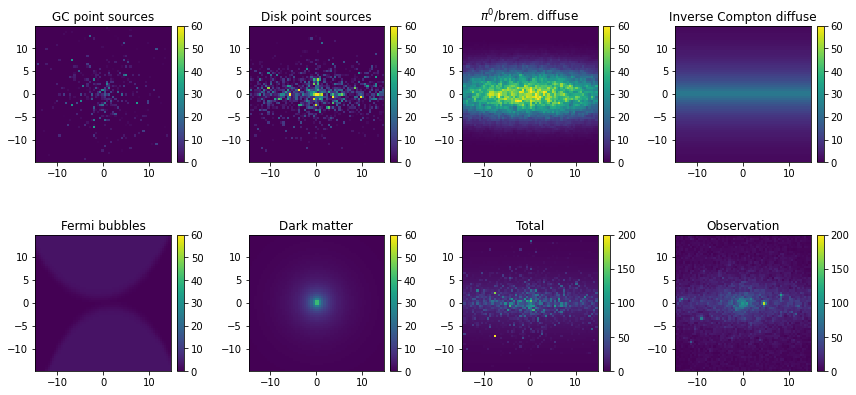

In [ ]:
sim = Simulator()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

ax = axes[0, 0]
hist = sim.sample_ps_gc(400, 1.0, 1.0)
im = ax.pcolormesh(sim.X, sim.Y, hist, vmin=0, vmax=60)
print("GC PS:", hist.mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("GC point sources")

ax = axes[0, 1]
hist = sim.sample_ps_disk(2000, 1.0, 1.0)
im = ax.pcolormesh(sim.X, sim.Y, hist, vmin=0, vmax=60)
print("Disk PS:", hist.mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Disk point sources")

ax = axes[0, 2]
im = ax.pcolormesh(sim.X, sim.Y, sim.sample_pi0(), vmin=0, vmax=60)
print("pi0:", sim.sample_pi0().mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(r"$\pi^0$/brem. diffuse")

ax = axes[0, 3]
im = ax.pcolormesh(sim.X, sim.Y, sim.emission_ic(), vmin=0, vmax=60)
print("IC:", sim.emission_ic().mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Inverse Compton diffuse")

ax = axes[1, 0]
im = ax.pcolormesh(sim.X, sim.Y, sim.emission_bubbles(), vmin=0, vmax=60)
print("Bubbles:", sim.emission_bubbles().mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Fermi bubbles")

ax = axes[1, 1]
im = ax.pcolormesh(sim.X, sim.Y, sim.emission_dm(), vmin=0, vmax=60)
print("DM:", sim.emission_dm().mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Dark matter")

ax = axes[1, 2]
im = ax.pcolormesh(sim.X, sim.Y, sim(1)[0]["mu"], vmin=0, vmax=200)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Total")

ax = axes[1, 3]
im = ax.pcolormesh(sim.X, sim.Y, sim(1)[0]["obs"], vmin=0, vmax=200)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Observation")

for ax in axes.flatten():
    ax.set_aspect("equal")

fig.tight_layout()

## Inference

In [ ]:
simulator = Simulator()
samples = simulator(10_000)

100%|██████████| 10000/10000 [03:16<00:00, 50.97it/s]


In [ ]:
# datamodule = sl.SwyftDataModule(store=samples, batch_size=64)

# Get train/test/val set sizes
n_samples = len(samples)
val_frac = 0.15
test_frac = 0.05
num_workers = 6
batch_size = 64
n_val = int(2 * ceil(n_samples * val_frac / 2))
n_test = int(2 * ceil(n_samples * test_frac / 2))
n_train = n_samples - n_val - n_test

# Get dataloaders
# resampler = simulator.get_resampler(("obs",))
dl_train = samples[0 : n_train - 1].get_dataloader(
    # num_workers=num_workers,
    batch_size=batch_size,
    # on_after_load_sample=resampler,
)
dl_val = samples[n_train : n_train + n_val - 1].get_dataloader(
    # num_workers=num_workers,
    batch_size=batch_size,
    # on_after_load_sample=resampler,
)
dl_test = samples[n_train + n_val : n_train + n_val + n_test - 1].get_dataloader(
    # num_workers=num_workers,
    batch_size=batch_size,
    # on_after_load_sample=resampler,
)

In [ ]:
from swyft.networks import OnlineDictStandardizingLayer
from torch import nn


class Network(sl.SwyftModule):
    def __init__(
        self,
        compressor_hidden_dim,
        n_compressor_features,
        classifier_hidden_dim,
        classifier_num_blocks,
        dropout_probability,
        n_pix,
    ):
        """
        References:
            Adapted from https://github.com/PyTorchLightning/Lightning-Bolts/blob/master/pl_bolts/models/gans/dcgan/dcgan_module.py
        """
        super().__init__()
        self.x_key = "obs"
        self.z_keys = ("A_ic", "A_pi0", "A_bubbles", "A_dm", "n_ps_gc", "n_ps_disk")
        self.n_compressor_features = n_compressor_features
        self.standardizing_layer = OnlineDictStandardizingLayer({self.x_key: (n_pix, n_pix)})
        self.compressor = nn.Sequential(
            self._make_compressor_block(1, compressor_hidden_dim, batch_norm=False),
            self._make_compressor_block(compressor_hidden_dim, compressor_hidden_dim * 2),
            self._make_compressor_block(compressor_hidden_dim * 2, compressor_hidden_dim * 4),
            self._make_compressor_block(compressor_hidden_dim * 4, compressor_hidden_dim * 8),
            self._make_compressor_block(
                compressor_hidden_dim * 8,
                self.n_compressor_features,
                kernel_size=4,
                stride=1,
                padding=0,
                last_block=True
            ),
        )
        # self.classifier = nn.Sequential(
        #     nn.Linear(self.n_compressor_features + len(self.z_keys), classifier_hidden_dim),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Dropout(p=dropout_probability),
        #     ###
        #     nn.Linear(classifier_hidden_dim, classifier_hidden_dim),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Dropout(p=dropout_probability),
        #     ###
        #     nn.Linear(classifier_hidden_dim, len(self.z_keys)),
        # )
        self.classifier = sl.RatioEstimatorMLP1d(
            self.n_compressor_features,
            len(self.z_keys),
            dropout_probability,
            classifier_hidden_dim,
            classifier_num_blocks,
        )

    @staticmethod
    def _make_compressor_block(
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
        bias: bool = False,
        batch_norm: bool = True,
        last_block: bool = False,
    ) -> nn.Sequential:
        if not last_block:
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.Sigmoid(),
            )

        return block

    def forward(self, x, z):
        # Standardize the observation
        x = x[self.x_key]
        x = self.standardizing_layer({self.x_key: x})[self.x_key]

        # Compress
        compression = self.compressor(x.unsqueeze(1)).view(-1, self.n_compressor_features)
        
        # Concatenate parameter values for which ratios are to be inferred
        z = torch.hstack([z[k] for k in self.z_keys])
        
        # Compute ratios
        out = self.classifier(compression, z)
        
        # Unpack ratios for each parameter
        return {k: sl.Ratios(out.values[..., i].unsqueeze(1), out.ratios[..., i].unsqueeze(1)) for i, k in enumerate(self.z_keys)}

In [ ]:
# Make sure the network works
sample = {k: v.cuda() for k, v in samples[0:64].items()}
Network(64, 64, 128, 3, 0.1, 64).cuda()(x=sample, z=sample);

In [ ]:
trainer = sl.SwyftTrainer(accelerator="gpu", gpus=1, max_epochs=30)
network = Network(64, 64, 128, 3, 0.1, 64)
trainer.fit(network, dl_train, dl_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                         | Params
---------------------------------------------------------------------
0 | standardizing_layer | OnlineDictStandardizingLayer | 0     
1 | compressor          | Sequential                   | 3.3 M 
2 | classifier          | RatioEstimatorMLP1d          | 655 K 
---------------------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.739    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 52.34it/s]


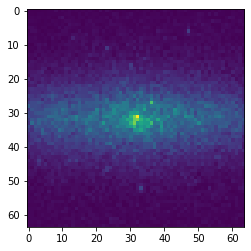

In [ ]:
# Select some observation to analyze
obs0 = simulator(1)[0]
plt.imshow(obs0["obs"])

In [ ]:
obs0.keys()

dict_keys(['A_ic', 'A_pi0', 'A_bubbles', 'A_dm', 'n_ps_gc', 'n_ps_disk', 'mu', 'obs'])

In [ ]:
# Draw samples from prior. These will be used to calculate the ratios.
prior_samples = simulator(20_000, targets=('A_ic', 'A_pi0', 'A_bubbles', 'A_dm', 'n_ps_gc', 'n_ps_disk'))
dl_prior = prior_samples.get_dataloader(1_024)
predictions = trainer.infer(network, {"obs": obs0["obs"]}, dl_prior)

100%|██████████| 20000/20000 [00:01<00:00, 14438.31it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 125it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


(0.0, 1.0)

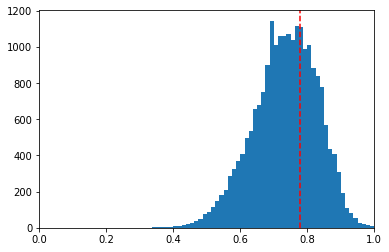

In [ ]:
plt.hist(
    predictions["A_dm"].values.numpy(),
    weights=predictions["A_dm"].weights().numpy(),
    bins=80
)
plt.axvline(obs0["A_dm"], color="r", linestyle="--")
plt.xlim(0, 1)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


(200.0, 800.0)

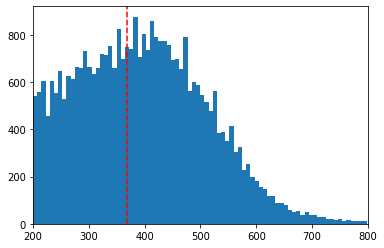

In [ ]:
plt.hist(
    predictions["n_ps_gc"].values.numpy(),
    weights=predictions["n_ps_gc"].weights().numpy(),
    bins=80
)
plt.axvline(obs0["n_ps_gc"], color="r", linestyle="--")
plt.xlim(200, 800)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


(1000.0, 4000.0)

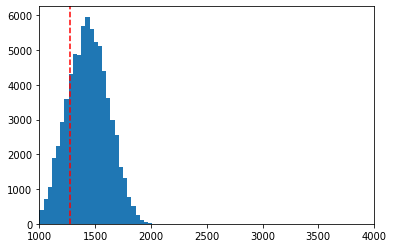

In [ ]:
plt.hist(
    predictions["n_ps_disk"].values.numpy(),
    weights=predictions["n_ps_disk"].weights().numpy(),
    bins=80
)
plt.axvline(obs0["n_ps_disk"], color="r", linestyle="--")
plt.xlim(1000, 4000)